In [1]:
from software.turbo import TurboM
import numpy as np
import matplotlib.pyplot as plt
import torch
import matplotlib.pyplot as plt
import os

/work/projects/p0020541/Yixuan/spinw/spinw_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import numpy as np

def ackley_function(x, a=20, b=0.2, c=2*np.pi):
    """
    计算d维Ackley函数。
    
    参数:
    x (np.array): 输入向量，维度为d。
    a, b, c (float): Ackley函数的参数。
    
    返回:
    float: 函数在x处的值。
    """
    d = len(x)
    sum_of_squares = np.sum(x**2)
    sum_of_cosines = np.sum(np.cos(c * x))
    
    term1 = -a * np.exp(-b * np.sqrt(sum_of_squares / d))
    term2 = -np.exp(sum_of_cosines / d)
    
    return term1 + term2 + a + np.exp(1)

In [6]:
class Spinw:
    def __init__(self, dim=4, lb=lb, ub=ub):
        self.dim = dim
        self.lb = lb
        self.ub = ub
        
    def __call__(self, x):
        assert len(x) == self.dim
        assert x.ndim == 1
        assert np.all(x <= self.ub) and np.all(x >= self.lb)
        
        loss = ackley_function(x)
        
        return loss

In [7]:
dimension = 10
lb = np.ones(dimension)*-10
ub = np.ones(dimension)*10
print(lb, ub)

f = Spinw(len(lb), lb, ub)

[-10. -10. -10. -10. -10. -10. -10. -10. -10. -10.] [10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]


In [9]:
turbo_m = TurboM(
    f=f,  # Handle to objective function
    lb=f.lb,  # Numpy array specifying lower bounds
    ub=f.ub,  # Numpy array specifying upper bounds
    n_init=4,  # Number of initial bounds from an Symmetric Latin hypercube design
    max_evals=100,  # Maximum number of evaluations
    n_trust_regions=2,  # Number of trust regions
    batch_size=2,  # How large batch size TuRBO uses
    verbose=True,  # Print information from each batch
    use_ard=True,  # Set to true if you want to use ARD for the GP kernel
    max_cholesky_size=1000,  # When we switch from Cholesky to Lanczos
    n_training_steps=50,  # Number of steps of ADAM to learn the hypers
    min_cuda=1024,  # Run on the CPU for small datasets
    device="cuda",  # "cpu" or "cuda"
    dtype="float64",  # float64 or float32
)

Using dtype = torch.float64 
Using device = cuda


In [10]:
turbo_m.optimize()

TR-0 starting from: 14.07
TR-1 starting from: 14.79


cat: /work/projects/p0020541/Yixuan/SpinWave/Expr_with_Kalman_filter/para_results.txt: No such file or directory


8) New best @ TR-0: 13.81
14) New best @ TR-0: 12.05
16) New best @ TR-0: 11.89
26) New best @ TR-0: 10.92
30) New best @ TR-0: 9.055
46) New best @ TR-0: 8.465
50) New best @ TR-0: 7.226
54) New best @ TR-0: 6.979
56) New best @ TR-0: 6.265
58) New best @ TR-0: 5.781
70) New best @ TR-0: 5.656
72) New best @ TR-0: 4.467
84) New best @ TR-0: 3.306
92) New best @ TR-0: 3.008


In [14]:
X = turbo_m.X  # Evaluated points
fX = turbo_m.fX  # Observed values
ind_best = np.argmin(fX)
f_best, x_best = fX[ind_best], X[ind_best, :]

print("Best value found:\n\tf(x) = %.3f\nObserved at:\n\tx = %s" % (f_best, np.around(x_best, 3)))

Best value found:
	f(x) = 3.008
Observed at:
	x = [ 0.141 -0.53  -0.722  0.124 -0.182 -0.877 -0.107  0.947 -0.042  0.073]


/tmp/ipykernel_2488944/3857413194.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("Best value found:\n\tf(x) = %.3f\nObserved at:\n\tx = %s" % (f_best, np.around(x_best, 3)))


In [12]:
print(ind_best)

92


In [102]:
print(fX[6])

[14.78683009]


In [138]:
import numpy as np

def cos_sim(A,B):
    cosine = np.dot(A,B)/(np.linalg.norm(A)*np.linalg.norm(B))
    return cosine

def candidate_selection(X, fX, max_size = None):

    ind_best = np.argmin(fX)
    ind_list = np.argsort(fX, axis=0).squeeze()
    
    sort_fX = fX[ind_list]
    sort_X = X[ind_list]

    screened_number = np.sum((sort_fX<fX[ind_best]*1.5)!=0)
    
    cos_similarity = [cos_sim(sort_X[0], i) for i in sort_X]
    select_fX = [sort_fX[0]]
    select_X = [sort_X[0]]
    select_index = [ind_list[0]]
    
    for i in range(1, screened_number):
        cosS = np.array([cos_sim(sort_X[i], j) for j in select_X])
        print((cosS<=0.9).all())
        if (cosS<=0.9).all():
            select_fX.append(sort_fX[i])
            select_X.append(sort_X[i])
            select_index.append(ind_list[i])        
    
    return np.array(select_X)[:max_size], np.array(select_fX)[:max_size], np.array(select_index)[:max_size]

In [ ]:
resX, resfX, resindex = candidate_selection(X, fX)
print(resindex)
print(len(resfX))
print(np.mean(resX, axis=1))
print(np.std(resX, axis=1))

In [1]:
print(resfX.squeeze())

NameError: name 'resfX' is not defined

In [145]:
print(resfX[-4:])

[[4.22329838]
 [4.43640105]
 [4.43819123]
 [4.46679271]]


In [3]:
import numpy as np
res = np.array([[4.22329838],
 [4.43640105],
 [4.43819123],
 [4.46679271]])

print(res)
print(res.squeeze())

[[4.22329838]
 [4.43640105]
 [4.43819123]
 [4.46679271]]
[4.22329838 4.43640105 4.43819123 4.46679271]


In [1]:
# 手搓卡尔曼滤波 from 华侨大学EDR战队
import numpy as np

class EDR_KalmanFilter:
    def __init__(self):
        self.A = np.matrix([[1, 0, 1, 0], [0, 1, 0, 1], [0, 0, 1, 0], [0, 0, 0, 1]], np.float32)  # 状态转移矩阵
        self.statePost = np.matrix(np.zeros((4,1),np.float32))  # 状态估计值
        self.statePre = np.matrix(np.zeros((4,1),np.float32))  # 状态预测值
        self.Q = np.matrix(np.eye(4))  # 过程噪声矩阵
        self.errorCovPost = np.matrix(np.zeros((4, 4),np.float32))  # 协方差矩阵的估计值
        self.errorCovPre = np.matrix(np.zeros((4, 4), np.float32))  # 协方差矩阵的预测值
        self.H = np.matrix(np.zeros((4, 2), np.float32))  # 卡尔曼滤波增益矩阵
        self.C = np.matrix([[1, 0, 0, 0], [0, 1, 0, 0]], np.float32)  # 状态观测矩阵
        self.R = np.matrix(np.eye(2))  # 观测噪声矩阵

    def predict(self):  # 按照卡尔曼滤波的公式1、2计算
        self.statePre = self.A * self.statePost  # 卡尔曼滤波公式1
        self.errorCovPre = self.A * self.errorCovPost * self.A.T + self.Q  # 卡尔曼滤波公式2
        return self.statePre  # 返回卡尔曼滤波的预测值

    def correct(self,measurement):  # 按照卡尔曼滤波的公式3、4、5计算
        self.H = self.errorCovPre * self.C.T * np.linalg.inv(self.C * self.errorCovPre * self.C.T + self.R)  # 卡尔曼滤波公式3
        self.statePost = self.statePre + self.H*(measurement - self.C * self.statePre)  # 卡尔曼滤波公式4
        self.errorCovPost = self.errorCovPre - self.H * self.C * self.errorCovPre  # 卡尔曼滤波公式5
        return self.statePost  # 返回卡尔曼滤波的估计值

    def getNext(self, x, y):  # 滤波器的输入输出在此
        measured = np.matrix([[np.float32(x)], [np.float32(y)]])
        self.predict()
        corrected = self.correct(measured)
        x, y = int(corrected[0]), int(corrected[1])
        return x, y

In [140]:
import numpy as np
import matplotlib.pyplot as plt

from software.MantidData import mantidOutput

### Reading Exper data and Exp_setup
def generate_exp_k_path(path_descriptions):
    'path description: list(K_path: str([[h1,k1,l1], [h2,k2,l2]]), Value: np.ndarray([h_value, k_value ,l_vaule]), grid: int(number))'
    'example usage: ["[[-h-1, 0, 0.5], [0, k+1, 0.5]]", [1, 1, 0], 300]] or ["[[1, -k, 0.5], [1, k, 0.5]]", [0, 2, 0], 300]'

    desc = path_descriptions[0]
    Kv = path_descriptions[1]
    path = eval(desc, {"h": Kv[0], "k": Kv[1], "l": Kv[2]})
    path.append(path_descriptions[2])

    return path

In [141]:
paths = ["[[1, -k, 0.5], [1, k, 0.5]]", "[[-h, 2, 0.5], [h, 2, 0.5]]", "[[-h-1, 0, 0.5], [0, k+1, 0.5]]"]
Expr = {1:{'Exp_info':['1K0E_slice_rotation_Ei70meV_5K.txt', paths[0]]}, 2:{'Exp_info':['H20E_slice_rotation_Ei70meV_5K.txt', paths[1]]}, 3:{'Exp_info':['Hm1Hp10E_slice_rotation_Ei70meV_5K.txt', paths[2]]}}
### part for furture application
Expr_grid = [None, None] #(Kpath_grid, Energy_grid)
    
for i in Expr.keys():
    testfile = f"files/data/{Expr[i]['Exp_info'][0]}"
    MO = mantidOutput(testfile)
    K = max(np.abs(np.min(np.round(MO.XX, 4))), np.abs(np.max(np.round(MO.XX, 4))))
    Expr[i]['Exp_info'].append(K)
    Expr[i]['Exp_Kgrid'] = [generate_exp_k_path([Expr[i]['Exp_info'][1], [K,K,K], len(MO.XX) if Expr_grid[0] is None else Expr_grid[0]]), K]
    Expr[i]['Exp_Egrid'] = [np.min(np.round(MO.YY, 4)), np.max(np.round(MO.YY, 4)), len(MO.YY) if Expr_grid[1] is None else Expr_grid[1]]

In [142]:
print(Expr)

print(Expr[1]['Exp_Egrid'])
print(Expr[1]['Exp_Kgrid'])

{1: {'Exp_info': ['1K0E_slice_rotation_Ei70meV_5K.txt', '[[1, -k, 0.5], [1, k, 0.5]]', 2.95], 'Exp_Kgrid': [[[1, -2.95, 0.5], [1, 2.95, 0.5], 60], 2.95], 'Exp_Egrid': [-4.625, 59.875, 87]}, 2: {'Exp_info': ['H20E_slice_rotation_Ei70meV_5K.txt', '[[-h, 2, 0.5], [h, 2, 0.5]]', 3.15], 'Exp_Kgrid': [[[-3.15, 2, 0.5], [3.15, 2, 0.5], 64], 3.15], 'Exp_Egrid': [-4.625, 59.875, 87]}, 3: {'Exp_info': ['Hm1Hp10E_slice_rotation_Ei70meV_5K.txt', '[[-h-1, 0, 0.5], [0, k+1, 0.5]]', 0.975], 'Exp_Kgrid': [[[-1.975, 0, 0.5], [0, 1.975, 0.5], 40], 0.975], 'Exp_Egrid': [-4.625, 59.875, 87]}}
[-4.625, 59.875, 87]
[[[1, -2.95, 0.5], [1, 2.95, 0.5], 60], 2.95]


In [143]:
import os
root_path = os.getcwd()+'/'
paths = ["[[1, -k, 0.5], [1, k, 0.5]]", "[[-h, 2, 0.5], [h, 2, 0.5]]", "[[-h-1, 0, 0.5], [0, k+1, 0.5]]"]

### In future the "txt file" can be subsitute to the experiment measurement function or the interface to the equipment
Expr = {0:{'Exp_info':['1K0E_slice_rotation_Ei70meV_5K.txt', paths[0]]}, 1:{'Exp_info':['H20E_slice_rotation_Ei70meV_5K.txt', paths[1]]}, 2:{'Exp_info':['Hm1Hp10E_slice_rotation_Ei70meV_5K.txt', paths[2]]}}

### part for furture application
Expr_grid = [None, None] #[Energy_grid, Kpath_grid]
    
for i in Expr.keys():
    testfile = f"{root_path}files/data/{Expr[i]['Exp_info'][0]}"
    MO = mantidOutput(testfile)
    K = max(np.abs(np.min(np.round(MO.XX, 4))), np.abs(np.max(np.round(MO.XX, 4))))
    Expr[i]['Exp_info'].append(K)
    Expr[i]['Exp_Kgrid'] = [generate_exp_k_path([Expr[i]['Exp_info'][1], [K,K,K], len(MO.XX) if Expr_grid[0] is None else Expr_grid[0]]), K]
    Expr[i]['Exp_Egrid'] = [np.min(np.round(MO.YY, 4)), np.max(np.round(MO.YY, 4)), len(MO.YY) if Expr_grid[1] is None else Expr_grid[1]]
    
### example output: {1: {'Exp_info': ['1K0E_slice_rotation_Ei70meV_5K.txt', '[[1, -k, 0.5], [1, k, 0.5]]', 2.95], 'Exp_Kgrid': [[[1, -2.95, 0.5], [1, 2.95, 0.5], 60], 2.95], 'Exp_Egrid': [-4.625, 59.875, 87]}, 2: {'Exp_info': ['H20E_slice_rotation_Ei70meV_5K.txt', '[[-h, 2, 0.5], [h, 2, 0.5]]', 3.15], 'Exp_Kgrid': [[[-3.15, 2, 0.5], [3.15, 2, 0.5], 64], 3.15], 'Exp_Egrid': [-4.625, 59.875, 87]}, 3: {'Exp_info': ['Hm1Hp10E_slice_rotation_Ei70meV_5K.txt', '[[-h-1, 0, 0.5], [0, k+1, 0.5]]', 0.975], 'Exp_Kgrid': [[[-1.975, 0, 0.5], [0, 1.975, 0.5], 40], 0.975], 'Exp_Egrid': [-4.625, 59.875, 87]}}

### Simulation_setup
img_shape = [500, 500] #[Energy_grid, Kpath_grid]
exp_img_shape = [[Expr[i]['Exp_Egrid'][2], Expr[i]['Exp_Kgrid'][0][2]] for i in Expr.keys()]

print(exp_img_shape)

# simulation Q and E for SpinW Simulation
Q_paths = [[Expr[i]['Exp_Kgrid'][0][0], Expr[i]['Exp_Kgrid'][0][1], img_shape[1]] for i in Expr.keys()] 
E_grid = [[Expr[i]['Exp_Egrid'][0], Expr[i]['Exp_Egrid'][1], img_shape[0]] for i in Expr.keys()]
energy_range = [[Expr[i]['Exp_Egrid'][0], Expr[i]['Exp_Egrid'][1]] for i in Expr.keys()]

# Experiment Q and E
Exp_Q_paths = [Expr[i]['Exp_Kgrid'][0] for i in Expr.keys()]
Exp_E_paths = [Expr[i]['Exp_Egrid'] for i in Expr.keys()]

[[87, 60], [87, 64], [87, 40]]


In [20]:
print(Q_paths)

[[[1, -2.95, 0.5], [1, 2.95, 0.5], 500], [[-3.15, 2, 0.5], [3.15, 2, 0.5], 500], [[-1.975, 0, 0.5], [0, 1.975, 0.5], 500]]


In [9]:
print(MO.II[80,30])
print(np.max(MO.II))
print(np.min(MO.II))


print(np.isnan(MO.II[80,30]))

print(MO.II)
print(type(MO.II))

nan
nan
nan
True
[[ 9.056402e-04  5.235130e-04  5.110282e-05 ...  2.408889e-04
   1.313619e-03  2.123862e-03]
 [ 2.206206e-03  2.620045e-03  7.418835e-05 ...  3.985501e-04
   1.977279e-03  4.819380e-03]
 [ 7.819379e-03  3.258644e-03  1.472670e-04 ...  6.791021e-04
   3.820106e-03  1.202537e-02]
 ...
 [-3.073567e-05 -2.882952e-05 -3.412843e-05 ...           nan
            nan           nan]
 [-3.578254e-05 -2.143099e-05  0.000000e+00 ...           nan
            nan           nan]
 [-2.474697e-05 -5.463848e-05           nan ...           nan
            nan           nan]]
<class 'numpy.ndarray'>


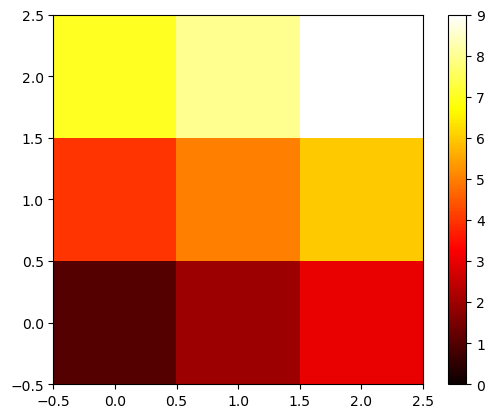

In [45]:
data = np.array([[1,2,3],
                 [4,5,6],
                 [7,8,9]])  # 生成一个3x3的随机矩阵
plt.imshow(data, vmin=0, vmax=9, cmap='hot', origin='lower')  # 绘制矩阵
plt.colorbar()  # 显示颜色条
plt.show()

In [87]:
def generate_initial_grid(interval, img_shape, test_num=0):

    #io = IO(root_path, test_num)
    
    rim_x = (img_shape[0]-int(img_shape[0]/interval)*interval)/2
    rim_y = (img_shape[1]-int(img_shape[1]/interval)*interval)/2
    x = np.arange(rim_x+int(interval/2), img_shape[0], interval)
    y = np.arange(rim_y+int(interval/2), img_shape[1], interval)
    
    xv, yv = np.meshgrid(x, y)
    grid_points = np.vstack([xv.ravel(), yv.ravel()]).T
    return grid_points

In [90]:
interval = 20

image_shape = [87, 60]

data = generate_initial_grid(interval, image_shape)

In [91]:
print(data)
print(type(data))

[[13.5 10. ]
 [33.5 10. ]
 [53.5 10. ]
 [73.5 10. ]
 [13.5 30. ]
 [33.5 30. ]
 [53.5 30. ]
 [73.5 30. ]
 [13.5 50. ]
 [33.5 50. ]
 [53.5 50. ]
 [73.5 50. ]]
<class 'numpy.ndarray'>


In [4]:
import numpy as np

data = np.random.random((5,5))
print(data)

print((0 <= data[:,0]).all() and (data[:,0] <= 0.5).any())

[[0.98510362 0.16122268 0.19352113 0.24386836 0.79754313]
 [0.11683737 0.27397715 0.05303312 0.82550604 0.75347854]
 [0.38377912 0.90028236 0.63514242 0.89833044 0.42075593]
 [0.45152973 0.39119181 0.37255266 0.57238276 0.42074579]
 [0.62973087 0.58848031 0.16238941 0.34434773 0.02384355]]
True


In [74]:
Data = np.random.randint(60, size=(5,2))+np.random.random((5,2))
print(Data)

E = np.random.random((5,2))*10
print(E)

simu_E = [-4, 60, 60]

simu_energy_to_index = (Data[:,0]-simu_E[0])/(simu_E[1]-simu_E[0])*simu_E[2]
print(simu_energy_to_index)
E[:,0] = np.array([np.around(i, 0) for i in simu_energy_to_index])

print(E)



# simu_index_to_energy = (simu_energy_to_index/simu_E[2])*(simu_E[1]-simu_E[0])+simu_E[0]
# print(simu_index_to_energy)

# simu_Q_to_index = (Q-self.simu_Q[0])/(self.simu_Q[1]-self.simu_Q[0])*self.simu_Q[2]
# simu_index_to_Q = (I/self.simu_Q[2])*(self.simu_Q[1]-self.simu_Q[0])+self.simu_Q[0]

# '''1. simu energy <-> simu index'''
# simu_energy_to_index = (E-self.simu_E[0])/(self.simu_E[1]-self.simu_E[0])*self.simu_E[2]
# simu_index_to_energy = (I/self.simu_E[2])*(self.simu_E[1]-self.simu_E[0])+self.simu_E[0]
# '''2. expr energy <-> expr index'''
# expr_energy_to_index = (EE-self.expr_E[0])/(self.expr_E[1]-self.expr_E[0])*self.expr_E[2]
# expr_index_to_energy = (EI/self.expr_E[2])*(self.expr_E[1]-self.expr_E[0])+self.expr_E[0]

# '''3. simu Qpath <-> simu index'''
# simu_Q_to_index = (Q-self.simu_Q[0])/(self.simu_Q[1]-self.simu_Q[0])*self.simu_Q[2]
# simu_index_to_Q = (I/self.simu_Q[2])*(self.simu_Q[1]-self.simu_Q[0])+self.simu_Q[0]
# '''4. expr Qpath <-> expr index'''
# expr_Q_to_index = (EE-self.expr_Q[0])/(self.expr_Q[1]-self.expr_Q[0])*self.expr_Q[2]
# expr_index_to_Q = (EI/self.expr_Q[2])*(self.expr_Q[1]-self.expr_Q[0])+self.expr_Q[0]


[[ 4.30451416 17.33612384]
 [ 3.66961237 23.88253923]
 [21.16750884 48.42209859]
 [54.5849817  43.2837486 ]
 [37.85094881  6.5523787 ]]
[[1.54368336 0.04508345]
 [0.48565559 2.59091011]
 [0.65751072 6.70294323]
 [7.13975751 7.99278607]
 [3.66816862 5.50269211]]
[ 7.78548202  7.19026159 23.59453954 54.92342034 39.23526451]
[[8.00000000e+00 4.50834534e-02]
 [7.00000000e+00 2.59091011e+00]
 [2.40000000e+01 6.70294323e+00]
 [5.50000000e+01 7.99278607e+00]
 [3.90000000e+01 5.50269211e+00]]


In [41]:
Kv = np.array([0, 0])
print(type(Kv))
Exp_K_path = [[[1, Kv[0], 0.5], [1, Kv[1], 0.5]], [[Kv[0], 2, 0.5], [Kv[1], 2, 0.5]], [[Kv[0]-1, 0, 0.5], [0, Kv[1]+1, 0.5]]]

<class 'numpy.ndarray'>


In [59]:
import numpy as np

def generate_exp_k_path(path_descriptions):

    desc = path_descriptions[0]
    Kv = path_descriptions[1]
    path = eval(desc, {"h": Kv[0], "k": Kv[1], "l": Kv[2]})
    path.append(path_descriptions[2])

    return path

# path description: [K_path: str, Value: np.ndarray([h, k ,l]), grid: int]
path_descriptions = [
    ["[[1, -k, 0.5], [1, k, 0.5]]", [2, 2, 2], 300], 
    ["[[-h, 2, 0.5], [h, 2, 0.5]]", [2, 2, 2], 300],
    ["[[-h-1, 0, 0.5], [0, k+1, 0.5]]", [1, 1, 1], 300]
]

# 生成 Exp_K_path
for desc in path_descriptions:
    Exp_K_path = generate_exp_k_path(desc)
    print(Exp_K_path)

[[1, -2, 0.5], [1, 2, 0.5], 300]
[[-2, 2, 0.5], [2, 2, 0.5], 300]
[[-2, 0, 0.5], [0, 2, 0.5], 300]


-2.95 2.95
-4.625 59.875
87
(60,)
[-2.95       -2.85       -2.75       -2.65       -2.55       -2.450001
 -2.350001   -2.250001   -2.150001   -2.050001   -1.950001   -1.850001
 -1.750001   -1.650001   -1.550001   -1.450001   -1.350002   -1.250002
 -1.150002   -1.050002   -0.950002   -0.8500021  -0.7500021  -0.6500022
 -0.5500023  -0.4500024  -0.3500025  -0.2500026  -0.1500027  -0.05000281
  0.04999709  0.149997    0.2499969   0.3499968   0.4499967   0.5499966
  0.6499965   0.7499964   0.8499963   0.9499962   1.049996    1.149996
  1.249996    1.349996    1.449996    1.549996    1.649996    1.749995
  1.849995    1.949995    2.049995    2.149995    2.249995    2.349995
  2.449995    2.549995    2.649995    2.749995    2.849994    2.949994  ]
[-4.625 -3.875 -3.125 -2.375 -1.625 -0.875 -0.125  0.625  1.375  2.125
  2.875  3.625  4.375  5.125  5.875  6.625  7.375  8.125  8.875  9.625
 10.375 11.125 11.875 12.625 13.375 14.125 14.875 15.625 16.375 17.125
 17.875 18.625 19.375 20.125 20.875 

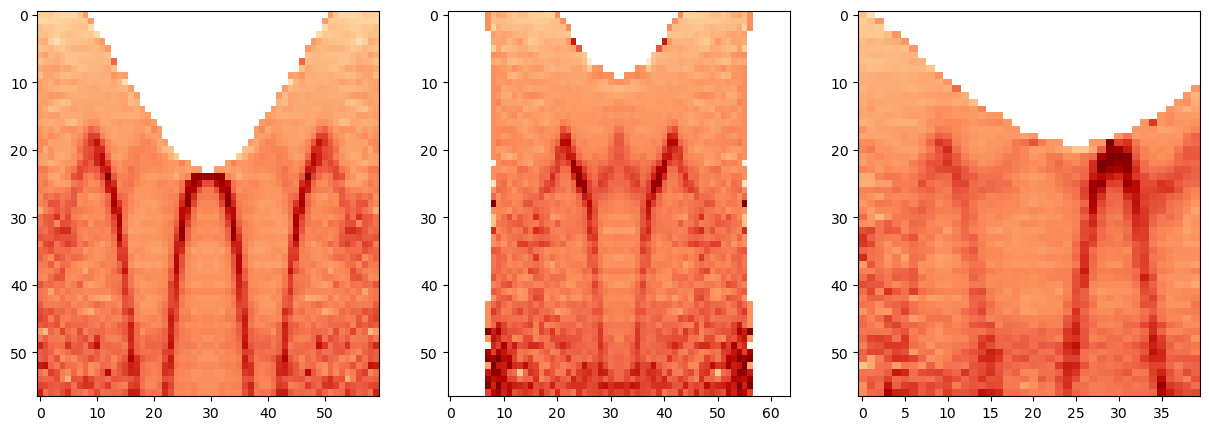

In [11]:
tests = ['1K0E_slice_rotation_Ei70meV_5K.txt','H20E_slice_rotation_Ei70meV_5K.txt','Hm1Hp10E_slice_rotation_Ei70meV_5K.txt']

fig, ax = plt.subplots(ncols=len(tests), figsize=(5*len(tests), 5))

for num,i in enumerate(tests):
    
    testfile = f'files/data/{i}'
    cmap = 'OrRd'
    MO = mantidOutput(testfile)
    print(np.min(np.round(MO.XX, 4)), np.max(np.round(MO.XX, 4)))
    print(np.min(np.round(MO.YY, 4)), np.max(np.round(MO.YY, 4)))
    
    print(len(MO.YY))#.shape)
    print(MO.XX.shape)
    
    print(MO.XX)
    print(MO.YY)
    
    # print(MO.II[81,30])
    print(MO.II.shape)
    print(np.max(np.nan_to_num(MO.II[20:,:])))
    print(np.min(np.nan_to_num(MO.II[20:,:])))
    # print(MO.II.shape)
    # print(MO.YY[0:12])
    

    #ax[num].pcolormesh(MO.XX[:], MO.YY[15:], MO.II[15:, :], vmin=0, vmax=np.max(np.nan_to_num(MO.II[15:,10:50])), cmap=cmap)
    ax[num].imshow(np.flipud(MO.II)[:-30,:], aspect='auto', vmax=0.0001, cmap='OrRd')
    #plt.pcolormesh(MO.XX[:], MO.YY[12:], np.nan_to_num(MO.II[12:, :]), vmin=0, vmax=np.max(np.nan_to_num(MO.II[15:,:])), cmap=cmap)

plt.show()

- Exp: 80*67 pixels
- Simu: 500*300 currently
- Info to be added: K_path grid xinfo + Energy yinfo
- 2D intensity interpolation
- non processing

In [20]:
import cv2

# Load an image
image = MO.II[15:, :]

new_width, new_height = 30,30

# Resize the image using different interpolation methods
nearest = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_NEAREST)
bilinear = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_LINEAR)
bicubic = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_CUBIC)
lanczos = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_LANCZOS4)

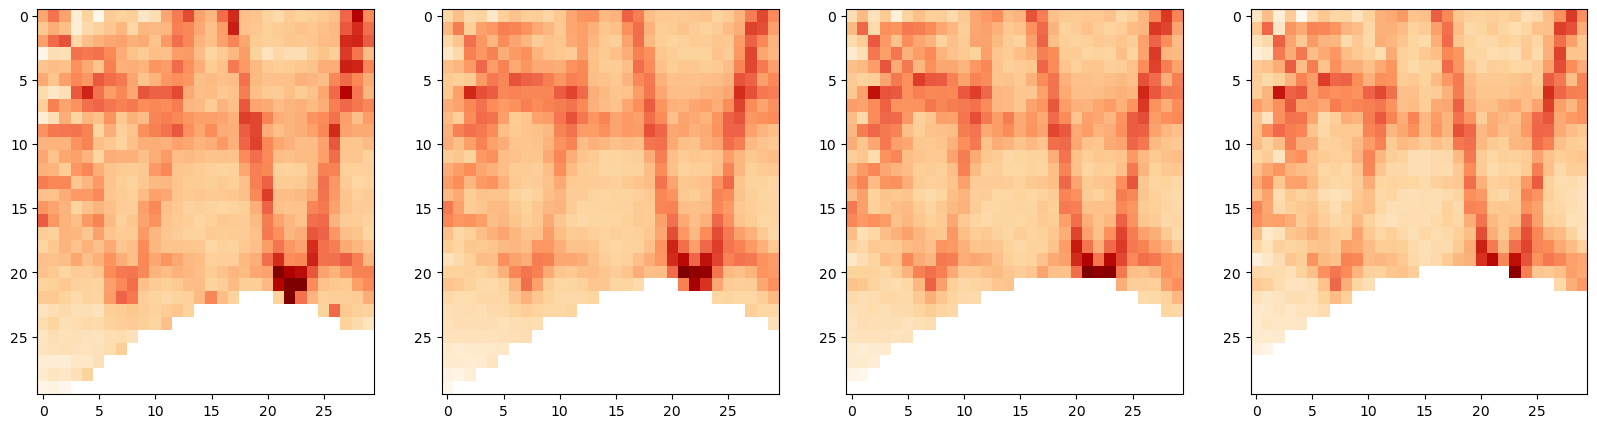

In [21]:
tests = [nearest, bilinear, bicubic, lanczos]

fig, ax = plt.subplots(ncols=len(tests), figsize=(5*len(tests), 5))

for num,i in enumerate(tests):
    
    testfile = f'files/data/{i}'
    cmap = 'OrRd'
    ax[num].imshow(i, aspect='auto', vmax=1e-4, cmap=cmap)

plt.show()

nan
(87, 64)
9.067561e-05
(87, 64)


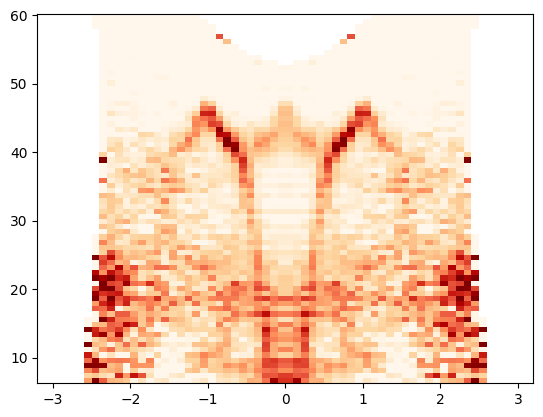

In [8]:
testfile = 'files/data/'
cmap = 'OrRd'
MO = mantidOutput(testfile)
print(MO.II[81,30])
print(MO.II.shape)
print(np.max(np.nan_to_num(MO.II[15:,10:50])))
print(MO.II.shape)

plt.figure()
plt.pcolormesh(MO.XX[:], MO.YY[15:], MO.II[15:, :], vmin=0, vmax=np.max(np.nan_to_num(MO.II[15:,10:50])), cmap=cmap)
#plt.pcolormesh(MO.XX[:], MO.YY[12:], np.nan_to_num(MO.II[12:, :]), vmin=0, vmax=np.max(np.nan_to_num(MO.II[15:,:])), cmap=cmap)

plt.show()

In [ ]:
testfile = 'data/'
cmap = 'OrRd'
MO = mantidOutput(testfile)
print(MO.II[81,30])
print(MO.II.shape)
print(np.max(np.nan_to_num(MO.II[15:,10:50])))
print(MO.II.shape)

plt.figure()
plt.pcolormesh(MO.XX[:], MO.YY[15:], MO.II[15:, :], vmin=0, vmax=np.max(np.nan_to_num(MO.II[15:,10:50])), cmap=cmap)
#plt.pcolormesh(MO.XX[:], MO.YY[12:], np.nan_to_num(MO.II[12:, :]), vmin=0, vmax=np.max(np.nan_to_num(MO.II[15:,:])), cmap=cmap)

plt.show()